In [57]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import random
from IPython.core.display import HTML
import shutil


#dropout_rate = 0.5
#fc_dropout_rate = 0.5

dropout_rate = 0.6
fc_dropout_rate = 0.5

#dropout_rate = 0.6
#fc_dropout_rate = 0.4


DATA_DIR = f'results_209_gn_lang_classification__dropout_{dropout_rate}__fc_dropout_{fc_dropout_rate}'

model_names = ['LangIdCNN_Mean2_FCD']


# DATA_DIR = 'results_008_gn_lang_classification__dropout_0.6__fc_dropout_0.5_contrastive'
# model_names = ["LangIdCNN_Mean2_FCD_Contrastive", "LangIdCNN_Mean2_FCD"]



random.seed(42)
#COLOR_PALETTE = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

COLOR_PALETTE = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#000000']
COLORS = ["#7f7f7f", "#1f77b4"]

BSLN_COLOR = '#7f7f7f'
OUR_COLOR = '#1f77b4'


n = 84
n_train = int(np.ceil(n * .6))
n_test = n - n_train


In [2]:
data_frames = {}

variable_names = []

for model_path in Path(DATA_DIR).iterdir():
    if not model_path.is_dir():
        continue
        
    if "NN" not in str(model_path):
        continue
    
    model_name = model_path.stem
    print(f"MODEL: {model_name}")
    fold_names = []
    
    data_frames[model_name] = {}
    
    for p in Path(model_path).iterdir():
        if not p.suffixes or p.suffixes[-1] != '.csv':
            continue
        fold_name = p.stem
        fold_names.append(fold_name)
        data_frames[model_name][fold_name] = pd.read_csv(p)
        variable_names.extend(list(data_frames[model_path.stem][p.stem].columns))
    for fold_name in sorted(fold_names):
        print(f"\t{fold_name}")

print(f"VARIABLES")        
for variable_name in sorted(set(variable_names)):
    print(f"\t{variable_name}")
        
    

MODEL: LangIdCNN_Mean2_FCD
	retrained-wav2vec_features-c_0
	retrained-wav2vec_features-c_1
	retrained-wav2vec_features-c_2
	retrained-wav2vec_features-c_3
	retrained-wav2vec_features-c_4
	retrained-wav2vec_features-c_5
	retrained-wav2vec_features-c_6
	retrained-wav2vec_features-c_7
	retrained-wav2vec_features-c_8
	retrained-wav2vec_features-c_9
	retrained-wav2vec_features-z_0
	retrained-wav2vec_features-z_1
	retrained-wav2vec_features-z_2
	retrained-wav2vec_features-z_3
	retrained-wav2vec_features-z_4
	retrained-wav2vec_features-z_5
	retrained-wav2vec_features-z_6
	retrained-wav2vec_features-z_7
	retrained-wav2vec_features-z_8
	retrained-wav2vec_features-z_9
	wav2vec_features-c_0
	wav2vec_features-c_1
	wav2vec_features-c_2
	wav2vec_features-c_3
	wav2vec_features-c_4
	wav2vec_features-c_5
	wav2vec_features-c_6
	wav2vec_features-c_7
	wav2vec_features-c_8
	wav2vec_features-c_9
	wav2vec_features-z_0
	wav2vec_features-z_1
	wav2vec_features-z_2
	wav2vec_features-z_3
	wav2vec_features-z_4
	wa

In [3]:
def get_variable_stats(model_name, feature_prefix, variable, sample_size):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
    
    m = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    
    
    
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    if variable == 'test_acc':
        print(f"{model_name}, {feature_prefix} {variable}, max-mean: {np.max(m)}, max-max: {np.max(maximum)}")
        # print(f"{model_name}, {feature_prefix} {variable}, max: {np.max(m_max)}, min {np.min(m_min)}")
        max_per_fold = np.max(data, axis=(0))
        print(np.mean(max_per_fold))
        
    return data, m, sem, minimum, maximum
    
        

In [4]:
def get_best_epochs_per_fold(model_name, feature_prefix, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    for index, df in enumerate(selected_dfs):
        best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    ep_best = np.argmax(best_epoch_selection_data, axis=0)
    
    return ep_best

def get_variable_stats(model_name, feature_prefix, variable, sample_size, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    #best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
        #best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    
    #
    # Stats of the variable @best epoch for each fold
    #
    #ep_best = np.argmax(best_epoch_selection_data, axis=0)
    ep_best = get_best_epochs_per_fold(model_name, feature_prefix, best_epoch_selection_variable)
    
    # value of the variable for the best epoch of each fold
    ep_best_values = [data[ep_best[fold_ix], fold_ix] for fold_ix in range(len(ep_best))]
    ep_best_mean = np.mean(ep_best_values)
    ep_best_sem = np.std(ep_best_values) / np.sqrt(sample_size)
    ep_best_min = np.min(ep_best_values)
    ep_best_max = np.max(ep_best_values)
    
    
    #
    # Stats of the variable @each epoch
    #
    mean = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    stats = {
        'data': data,
        'epochs_mean': mean,
        'epochs_sem': sem,
        'epochs_min': minimum,
        'epochs_max': maximum,
        
        'best_epoch_mean': ep_best_mean,
        'best_epoch_sem': ep_best_sem,
        'best_epoch_min': ep_best_min,
        'best_epoch_max': ep_best_max
    }
    
    #if variable == 'test_acc':
    #    print(f"{model_name}, {feature_prefix} {variable}")
    #    [print(f"max {k}", np.max(v)) for k,v in stats.items() if k != 'data']
        
    return stats

In [5]:
def plot_comparative_variables(ax, model_name, feature_prefixes, variable, sample_size):
    line_styles = ['-', '-']
    for index, feature_prefix in enumerate(feature_prefixes):
        stats = get_variable_stats(model_name, feature_prefix, variable, sample_size)
        
        x = range(1, stats['data'].shape[0]+1)

        ax.plot(x, stats['epochs_mean'], color=COLORS[index], linestyle=line_styles[index], label=f'{model_name} {feature_prefix}', alpha=1)
        
        ax.fill_between(
            x, 
            stats['epochs_mean'] + stats['epochs_sem'], 
            stats['epochs_mean'] - stats['epochs_sem'], 
            color=COLORS[index], alpha=0.6
        )
        
        ax.fill_between(
            x, 
            stats['epochs_min'], 
            stats['epochs_max'], 
            color=COLORS[index], alpha=0.1
        )

    ax.grid(True)
    ax.title.set_text(variable)
    ax.legend()

In [6]:
def plot_results(model_names, variables_and_sample_sizes, compared_features):
    variables = [t[0] for t in variables_and_sample_sizes]
    sample_sizes_by_variable = {t[0]:t[1] for t in variables_and_sample_sizes}

    plot_width = len(model_names)*10
    plot_height = len(variables)*10
    fig, axes = plt.subplots(len(variables), len(model_names), sharex=True, sharey='row', figsize=(plot_width, plot_height))
    axes = axes.reshape(len(variables), len(model_names))
    for variable_index, variable in enumerate(variables):
        # fig, axes = plt.subplots(1, len(model_names), sharex=True, sharey=True, figsize=(20, 7))
        sample_size = sample_sizes_by_variable[variable]
        for model_index, model_name in enumerate(model_names):
            plot_comparative_variables(
                axes[variable_index, model_index], # axes[variable_index]
                model_name,
                compared_features,
                variable,
                sample_size
            )

In [7]:
# def plot_best_results(model_names, variables_and_sample_sizes, model_selection_variable, compared_features):
    

In [8]:
fold_count = 10


# test_acc
# test_acc_channel_music
# test_acc_channel_noise
# test_acc_channel_telephone
# test_acc_gender_female
# test_acc_gender_male
# test_acc_language_maninka
# test_acc_language_pular
# test_acc_language_susu
# test_acc_speaker_count_multiple
# test_acc_speaker_count_single
# test_acc_utterance_multilingual
# test_acc_utterance_verbal_nod


    
#variables_and_sample_sizes = [
#    ('train_loss', n_train),
#    ('test_loss', n_test),
#    ('train_acc', n_train),
#    ('test_acc', n_test),
#    ('test_acc_gender_male', n_test),
#    ('test_acc_gender_female', n_test),
#    ('test_acc_language_maninka', n_test),
#    ('test_acc_language_pular', n_test),
#    ('test_acc_language_susu', n_test)
#]


variables_and_sample_sizes = [
    ('train_loss', fold_count),
    ('test_loss', fold_count),
    ('train_acc', fold_count),
    ('test_acc', fold_count),
    
    ('test_acc_gender_male', fold_count),
    ('test_acc_gender_female', fold_count),
    
    ('test_acc_language_maninka', fold_count),
    ('test_acc_language_pular', fold_count),
    ('test_acc_language_susu', fold_count),
    
    ('test_acc_speaker_count_multiple', fold_count),
    ('test_acc_speaker_count_single', fold_count),
    
    
    ('test_acc_utterance_multilingual', fold_count),
    ('test_acc_utterance_verbal_nod', fold_count),
    
    
    ('test_acc_channel_music', fold_count),
    ('test_acc_channel_noise', fold_count),
    ('test_acc_channel_telephone', fold_count),
    
    ('test_n', fold_count),
    ('test_n_channel_music', fold_count),
    ('test_n_channel_noise', fold_count),
    ('test_n_channel_telephone', fold_count),
    ('test_n_gender_female', fold_count),
    ('test_n_gender_male', fold_count),
    ('test_n_language_maninka', fold_count),
    ('test_n_language_pular', fold_count),
    ('test_n_language_susu', fold_count),
    ('test_n_speaker_count_multiple', fold_count),
    ('test_n_speaker_count_single', fold_count),
    ('test_n_utterance_multilingual', fold_count),
    ('test_n_utterance_verbal_nod', fold_count),

]


# Language classification with context features

In [9]:
#compared_features = ['wav2vec_features-c', 'retrained-wav2vec_features-c']
#plot_results(model_names, variables_and_sample_sizes, compared_features)

# Language Classification With Latent Features

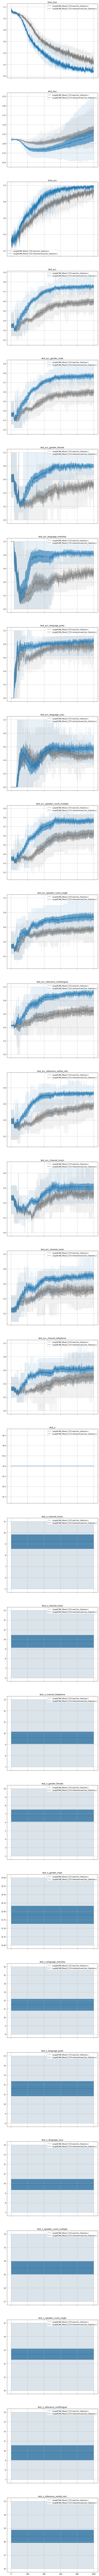

In [10]:
compared_features = ['wav2vec_features-z', 'retrained-wav2vec_features-z']
plot_results(model_names, variables_and_sample_sizes, compared_features)

# Best epoch summaries

In [11]:
def make_label_str(model_name, feature_name):
    m_name = model_name.replace('LangId','')# .replace("1", "")

    f_name = feature_name.replace(
        "retrained-wav2vec_features-z", "OUR  Latent"
    ).replace(
        "retrained-wav2vec_features-c", "OUR  Context"
    ).replace(
        "wav2vec_features-z", "BSLN  Latent"
    ).replace(
        "wav2vec_features-c", "BSLN  Context"
    )


    # return m_name, f_name
    return f"{f_name} - {m_name}"

In [12]:
def plot_summary_results(model_names, variables_and_sample_sizes, compared_features):
    variables = [t[0] for t in variables_and_sample_sizes]
    sample_sizes_by_variable = {t[0]:t[1] for t in variables_and_sample_sizes}
    
    series_means = {v:[] for v in variables}
    series_sems = {v:[] for v in variables}
    series_mins = {v:[] for v in variables}
    series_maxes = {v:[] for v in variables}
    
    series_labels = {v:[] for v in variables}
    
    for variable in variables:
        for feature_prefix in compared_features:
            sample_size = sample_sizes_by_variable[variable]
            for model_name in model_names:
                stats = get_variable_stats(model_name, feature_prefix, variable, sample_size)
                series_means[variable].append(stats['best_epoch_mean'])
                series_sems[variable].append(stats['best_epoch_sem'])
                series_mins[variable].append(stats['best_epoch_min'])
                series_maxes[variable].append(stats['best_epoch_max'])
                series_labels[variable].append((model_name, feature_prefix))
    
    for v in variables:
        df = pd.DataFrame(
            data={
                f'{v}_labels': [make_label_str(l[0], l[1]) for l in series_labels[v]],
                f'{v}_means': series_means[v],
                f'{v}_sems': series_sems[v],
            }
        )
        display(df)
    
    # Variables
    # 'train_loss', 'test_loss', 
    # 'train_acc', 'test_acc', 
    # 'test_acc_gender_male', 'test_acc_gender_female', 
    # 'test_acc_language_maninka', 'test_acc_language_pular', 'test_acc_language_susu'
    
    fig, ax = plt.subplots(figsize=(15, 10))
    #plt.bar(labels, mean_train_acc)
    #print(labels)
    bar_width = 5
    bar_margin = 20
    
    label_count = len(series_labels['test_acc'])
    
    colors = {
        "male": "#58508d",
        "female": "#ff6361",
        "maninka": "#88290d",
        "susu": "#b44f0f",
        "pular": "#dc790b",
        "train": "#7f7f7f",
        "test":"#4682b4"
    }

    
    #('test_acc_speaker_count_multiple', fold_count),
    #('test_acc_speaker_count_single', fold_count),
    
    
    #('test_acc_utterance_multilingual', fold_count),
    #('test_acc_utterance_verbal_nod', fold_count),
    
    
    #('test_acc_channel_music', fold_count),
    #('test_acc_channel_noise', fold_count),
    #('test_acc_channel_telephone', fold_count)
    

    train_y_pos = (bar_width+bar_margin)*np.arange(label_count)
    test_y_pos =(bar_width+bar_margin)*np.arange(label_count)
    test_y_male_pos =(bar_width+bar_margin)*np.arange(label_count) + 3.5
    test_y_female_pos =(bar_width+bar_margin)*np.arange(label_count) + 4.5
    
    test_y_susu_pos =(bar_width+bar_margin)*np.arange(label_count) + 6
    test_y_maninka_pos =(bar_width+bar_margin)*np.arange(label_count) + 7
    test_y_pular_pos =(bar_width+bar_margin)*np.arange(label_count) + 8
    
    test_y_speaker_multi = (bar_width+bar_margin)*np.arange(label_count) + 9.5
    test_y_speaker_single = (bar_width+bar_margin)*np.arange(label_count) + 10.5
    
    test_y_utt_multilingual = (bar_width+bar_margin)*np.arange(label_count) + 12
    test_y_utt_verbal_nod = (bar_width+bar_margin)*np.arange(label_count) + 13
    
    test_y_channel_music = (bar_width+bar_margin)*np.arange(label_count) + 14.5
    test_y_channel_noise = (bar_width+bar_margin)*np.arange(label_count) + 15.5
    test_y_channel_telephone = (bar_width+bar_margin)*np.arange(label_count) + 16.5


    ax.barh(train_y_pos, series_means['train_acc'], height=5, xerr=series_sems['train_acc'], color=colors['train'])
    ax.barh(test_y_pos, series_means['test_acc'], height=5, xerr=series_sems['test_acc'], color=colors['test']) # color=COLORS[2]
    
    bias_alpha = 0.6
    ax.barh(test_y_male_pos, series_means['test_acc_gender_male'], height=1, xerr=series_sems['test_acc_gender_male'], color=colors['male'], alpha=bias_alpha)
    ax.barh(test_y_female_pos, series_means['test_acc_gender_female'], height=1, xerr=series_sems['test_acc_gender_female'], color=colors['female'], alpha=bias_alpha)
    
    ax.barh(test_y_susu_pos, series_means['test_acc_language_susu'], height=1, xerr=series_sems['test_acc_language_susu'], color=colors['susu'], alpha=bias_alpha)
    ax.barh(test_y_maninka_pos, series_means['test_acc_language_maninka'], height=1, xerr=series_sems['test_acc_language_maninka'], color=colors['maninka'], alpha=bias_alpha)
    ax.barh(test_y_pular_pos, series_means['test_acc_language_pular'], height=1, xerr=series_sems['test_acc_language_pular'], color=colors['pular'], alpha=bias_alpha)
    
    ax.barh(test_y_speaker_multi, series_means['test_acc_speaker_count_multiple'], height=1, xerr=series_sems['test_acc_speaker_count_multiple'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_speaker_single, series_means['test_acc_speaker_count_single'], height=1, xerr=series_sems['test_acc_speaker_count_single'], color=colors['pular'], alpha=bias_alpha)
    
    ax.barh(test_y_utt_multilingual, series_means['test_acc_utterance_multilingual'], height=1, xerr=series_sems['test_acc_utterance_multilingual'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_utt_verbal_nod, series_means['test_acc_utterance_verbal_nod'], height=1, xerr=series_sems['test_acc_utterance_verbal_nod'], color=colors['pular'], alpha=bias_alpha)

    ax.barh(test_y_channel_music, series_means['test_acc_channel_music'], height=1, xerr=series_sems['test_acc_channel_music'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_channel_noise, series_means['test_acc_channel_noise'], height=1, xerr=series_sems['test_acc_channel_noise'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_channel_telephone, series_means['test_acc_channel_telephone'], height=1, xerr=series_sems['test_acc_channel_telephone'], color=colors['pular'], alpha=bias_alpha)

    for i, label in enumerate(series_labels['test_acc']):
        (model_name, feature_name) = label

        
        
        label_str = make_label_str(model_name, feature_name)

        train_acc_label_str = f"{series_means['train_acc'][i]:.02%}"
        test_acc_label_str = f"{series_means['test_acc'][i]:.02%}"

        ax.text(0.01, train_y_pos[i], label_str, color='white', fontsize="x-large", fontweight="bold")

        ax.text(series_means['train_acc'][i]-0.07, train_y_pos[i]-0.7, train_acc_label_str, color='white', fontsize="large")
        ax.text(series_means['test_acc'][i]-0.07, train_y_pos[i]-0.7, test_acc_label_str, color='white', fontsize="large")
        

        
        ax.text(0.01, test_y_male_pos[i]-0.3, f"male ({series_means['test_n_gender_male'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_female_pos[i]-0.3, f"female ({series_means['test_n_gender_female'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_susu_pos[i]-0.3, f"susu ({series_means['test_n_language_susu'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_maninka_pos[i]-0.3, f"maninka ({series_means['test_n_language_maninka'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_pular_pos[i]-0.3, f"pular ({series_means['test_n_language_pular'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_speaker_multi[i]-0.3, f"multi speakers ({series_means['test_n_speaker_count_multiple'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_speaker_single[i]-0.3, f"single speaker ({series_means['test_n_speaker_count_single'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_utt_multilingual[i]-0.3, f"multi-lingual utt ({series_means['test_n_utterance_multilingual'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_utt_verbal_nod[i]-0.3, f"verbal nod utt ({series_means['test_n_utterance_verbal_nod'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_channel_music[i]-0.3, f"music ({series_means['test_n_channel_music'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_channel_noise[i]-0.3, f"noise ({series_means['test_n_channel_noise'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_channel_telephone[i]-0.3, f"telephone ({series_means['test_n_channel_telephone'][i]})", color='black', fontsize="small")
        
        
        ax.legend(["TRAIN", "TEST", "TEST (Male)", "TEST (Female)", "TEST (Susu)", "TEST (Maninka)", "TEST (Pular)"])
        ax.set_xlim(0, 1)
        ax.get_yaxis().set_ticks([])
        ax.set_title(f"Average and SEM (n=10 folds) Language Identification Accuracies. Conv Dropout p={dropout_rate}. FC Dropout p={fc_dropout_rate}")
        ax.grid(True)

        
        


train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Latent - CNN_Mean2_FCD          0.437277         0.042475
1   OUR  Latent - CNN_Mean2_FCD          0.313531         0.046576

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Latent - CNN_Mean2_FCD         1.092899        0.066766
1   OUR  Latent - CNN_Mean2_FCD         0.813721        0.055500

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Latent - CNN_Mean2_FCD         0.798039        0.030256
1   OUR  Latent - CNN_Mean2_FCD         0.903922        0.025783

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Latent - CNN_Mean2_FCD        0.651515       0.021957
1   OUR  Latent - CNN_Mean2_FCD        0.790909       0.013174

test_acc_gender_male_labels  test_acc_gender_male_means  \
0  BSLN  Latent - CNN_Mean2_FCD                    0.655627   
1   OUR  Latent - CNN_Mean2_FCD                    0.806317   

   test_acc_gender_male_sems  
0                   0.022806  
1                   0.017025

test_acc_gender_female_labels  test_acc_gender_female_means  \
0  BSLN  Latent - CNN_Mean2_FCD                      0.577698   
1   OUR  Latent - CNN_Mean2_FCD                      0.830159   

   test_acc_gender_female_sems  
0                     0.061760  
1                     0.032523

test_acc_language_maninka_labels  test_acc_language_maninka_means  \
0     BSLN  Latent - CNN_Mean2_FCD                         0.580525   
1      OUR  Latent - CNN_Mean2_FCD                         0.884259   

   test_acc_language_maninka_sems  
0                        0.058903  
1                        0.024420

test_acc_language_pular_labels  test_acc_language_pular_means  \
0   BSLN  Latent - CNN_Mean2_FCD                       0.789651   
1    OUR  Latent - CNN_Mean2_FCD                       0.837588   

   test_acc_language_pular_sems  
0                      0.036444  
1                      0.029270

test_acc_language_susu_labels  test_acc_language_susu_means  \
0  BSLN  Latent - CNN_Mean2_FCD                      0.600837   
1   OUR  Latent - CNN_Mean2_FCD                      0.634401   

   test_acc_language_susu_sems  
0                     0.043971  
1                     0.043694

test_acc_speaker_count_multiple_labels  \
0           BSLN  Latent - CNN_Mean2_FCD   
1            OUR  Latent - CNN_Mean2_FCD   

   test_acc_speaker_count_multiple_means  test_acc_speaker_count_multiple_sems  
0                               0.662748                              0.030207  
1                               0.801688                              0.018832

test_acc_speaker_count_single_labels  test_acc_speaker_count_single_means  \
0         BSLN  Latent - CNN_Mean2_FCD                             0.636777   
1          OUR  Latent - CNN_Mean2_FCD                             0.765714   

   test_acc_speaker_count_single_sems  
0                            0.035611  
1                            0.037403

test_acc_utterance_multilingual_labels  \
0           BSLN  Latent - CNN_Mean2_FCD   
1            OUR  Latent - CNN_Mean2_FCD   

   test_acc_utterance_multilingual_means  test_acc_utterance_multilingual_sems  
0                               0.676294                              0.054689  
1                               0.909780                              0.032297

test_acc_utterance_verbal_nod_labels  test_acc_utterance_verbal_nod_means  \
0         BSLN  Latent - CNN_Mean2_FCD                             0.602388   
1          OUR  Latent - CNN_Mean2_FCD                             0.775064   

   test_acc_utterance_verbal_nod_sems  
0                            0.026791  
1                            0.025625

test_acc_channel_music_labels  test_acc_channel_music_means  \
0  BSLN  Latent - CNN_Mean2_FCD                      0.621039   
1   OUR  Latent - CNN_Mean2_FCD                      0.675747   

   test_acc_channel_music_sems  
0                     0.046119  
1                     0.040463

test_acc_channel_noise_labels  test_acc_channel_noise_means  \
0  BSLN  Latent - CNN_Mean2_FCD                      0.629503   
1   OUR  Latent - CNN_Mean2_FCD                      0.764821   

   test_acc_channel_noise_sems  
0                     0.034935  
1                     0.016843

test_acc_channel_telephone_labels  test_acc_channel_telephone_means  \
0      BSLN  Latent - CNN_Mean2_FCD                          0.544356   
1       OUR  Latent - CNN_Mean2_FCD                          0.682121   

   test_acc_channel_telephone_sems  
0                         0.033040  
1                         0.033187

test_n_labels  test_n_means  test_n_sems
0  BSLN  Latent - CNN_Mean2_FCD          33.0          0.0
1   OUR  Latent - CNN_Mean2_FCD          33.0          0.0

test_n_channel_music_labels  test_n_channel_music_means  \
0  BSLN  Latent - CNN_Mean2_FCD                         9.2   
1   OUR  Latent - CNN_Mean2_FCD                         9.2   

   test_n_channel_music_sems  
0                   0.629285  
1                   0.629285

test_n_channel_noise_labels  test_n_channel_noise_means  \
0  BSLN  Latent - CNN_Mean2_FCD                         9.8   
1   OUR  Latent - CNN_Mean2_FCD                         9.8   

   test_n_channel_noise_sems  
0                   0.644981  
1                   0.644981

test_n_channel_telephone_labels  test_n_channel_telephone_means  \
0    BSLN  Latent - CNN_Mean2_FCD                             9.6   
1     OUR  Latent - CNN_Mean2_FCD                             9.6   

   test_n_channel_telephone_sems  
0                       0.532917  
1                       0.532917

test_n_gender_female_labels  test_n_gender_female_means  \
0  BSLN  Latent - CNN_Mean2_FCD                         6.8   
1   OUR  Latent - CNN_Mean2_FCD                         6.8   

   test_n_gender_female_sems  
0                   0.704273  
1                   0.704273

test_n_gender_male_labels  test_n_gender_male_means  \
0  BSLN  Latent - CNN_Mean2_FCD                      31.9   
1   OUR  Latent - CNN_Mean2_FCD                      31.9   

   test_n_gender_male_sems  
0                 0.262679  
1                 0.262679

test_n_language_maninka_labels  test_n_language_maninka_means  \
0   BSLN  Latent - CNN_Mean2_FCD                           11.5   
1    OUR  Latent - CNN_Mean2_FCD                           11.5   

   test_n_language_maninka_sems  
0                      0.681909  
1                      0.681909

test_n_language_pular_labels  test_n_language_pular_means  \
0  BSLN  Latent - CNN_Mean2_FCD                         11.6   
1   OUR  Latent - CNN_Mean2_FCD                         11.6   

   test_n_language_pular_sems  
0                    0.764199  
1                    0.764199

test_n_language_susu_labels  test_n_language_susu_means  \
0  BSLN  Latent - CNN_Mean2_FCD                         9.9   
1   OUR  Latent - CNN_Mean2_FCD                         9.9   

   test_n_language_susu_sems  
0                   0.555878  
1                   0.555878

test_n_speaker_count_multiple_labels  test_n_speaker_count_multiple_means  \
0         BSLN  Latent - CNN_Mean2_FCD                                 19.5   
1          OUR  Latent - CNN_Mean2_FCD                                 19.5   

   test_n_speaker_count_multiple_sems  
0                            0.474342  
1                            0.474342

test_n_speaker_count_single_labels  test_n_speaker_count_single_means  \
0       BSLN  Latent - CNN_Mean2_FCD                               12.7   
1        OUR  Latent - CNN_Mean2_FCD                               12.7   

   test_n_speaker_count_single_sems  
0                          0.401248  
1                          0.401248

test_n_utterance_multilingual_labels  test_n_utterance_multilingual_means  \
0         BSLN  Latent - CNN_Mean2_FCD                                  9.8   
1          OUR  Latent - CNN_Mean2_FCD                                  9.8   

   test_n_utterance_multilingual_sems  
0                            0.758947  
1                            0.758947

test_n_utterance_verbal_nod_labels  test_n_utterance_verbal_nod_means  \
0       BSLN  Latent - CNN_Mean2_FCD                               18.4   
1        OUR  Latent - CNN_Mean2_FCD                               18.4   

   test_n_utterance_verbal_nod_sems  
0                          0.473286  
1                          0.473286

train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Context - CNN_Mean2_FCD          0.672714         0.102312
1   OUR  Context - CNN_Mean2_FCD          0.321740         0.050488

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Context - CNN_Mean2_FCD         1.757919        0.429730
1   OUR  Context - CNN_Mean2_FCD         0.871998        0.089717

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Context - CNN_Mean2_FCD         0.652941        0.075180
1   OUR  Context - CNN_Mean2_FCD         0.864706        0.033212

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Context - CNN_Mean2_FCD        0.606061       0.006061
1   OUR  Context - CNN_Mean2_FCD        0.784848       0.015121

test_acc_gender_male_labels  test_acc_gender_male_means  \
0  BSLN  Context - CNN_Mean2_FCD                    0.611455   
1   OUR  Context - CNN_Mean2_FCD                    0.793313   

   test_acc_gender_male_sems  
0                   0.008966  
1                   0.013879

test_acc_gender_female_labels  test_acc_gender_female_means  \
0  BSLN  Context - CNN_Mean2_FCD                      0.617540   
1   OUR  Context - CNN_Mean2_FCD                      0.839206   

   test_acc_gender_female_sems  
0                     0.038732  
1                     0.058878

test_acc_language_maninka_labels  test_acc_language_maninka_means  \
0    BSLN  Context - CNN_Mean2_FCD                         0.703128   
1     OUR  Context - CNN_Mean2_FCD                         0.800925   

   test_acc_language_maninka_sems  
0                        0.034427  
1                        0.042630

test_acc_language_pular_labels  test_acc_language_pular_means  \
0  BSLN  Context - CNN_Mean2_FCD                       0.724323   
1   OUR  Context - CNN_Mean2_FCD                       0.882030   

   test_acc_language_pular_sems  
0                      0.039120  
1                      0.027597

test_acc_language_susu_labels  test_acc_language_susu_means  \
0  BSLN  Context - CNN_Mean2_FCD                      0.346104   
1   OUR  Context - CNN_Mean2_FCD                      0.670245   

   test_acc_language_susu_sems  
0                     0.073261  
1                     0.038795

test_acc_speaker_count_multiple_labels  \
0          BSLN  Context - CNN_Mean2_FCD   
1           OUR  Context - CNN_Mean2_FCD   

   test_acc_speaker_count_multiple_means  test_acc_speaker_count_multiple_sems  
0                               0.604163                              0.025610  
1                               0.827089                              0.033808

test_acc_speaker_count_single_labels  test_acc_speaker_count_single_means  \
0        BSLN  Context - CNN_Mean2_FCD                             0.594414   
1         OUR  Context - CNN_Mean2_FCD                             0.745971   

   test_acc_speaker_count_single_sems  
0                            0.032502  
1                            0.037501

test_acc_utterance_multilingual_labels  \
0          BSLN  Context - CNN_Mean2_FCD   
1           OUR  Context - CNN_Mean2_FCD   

   test_acc_utterance_multilingual_means  test_acc_utterance_multilingual_sems  
0                               0.648828                              0.050992  
1                               0.852552                              0.023224

test_acc_utterance_verbal_nod_labels  test_acc_utterance_verbal_nod_means  \
0        BSLN  Context - CNN_Mean2_FCD                             0.585153   
1         OUR  Context - CNN_Mean2_FCD                             0.764521   

   test_acc_utterance_verbal_nod_sems  
0                            0.024336  
1                            0.023349

test_acc_channel_music_labels  test_acc_channel_music_means  \
0  BSLN  Context - CNN_Mean2_FCD                      0.522143   
1   OUR  Context - CNN_Mean2_FCD                      0.642597   

   test_acc_channel_music_sems  
0                     0.025738  
1                     0.041837

test_acc_channel_noise_labels  test_acc_channel_noise_means  \
0  BSLN  Context - CNN_Mean2_FCD                      0.536233   
1   OUR  Context - CNN_Mean2_FCD                      0.747620   

   test_acc_channel_noise_sems  
0                     0.035722  
1                     0.040901

test_acc_channel_telephone_labels  test_acc_channel_telephone_means  \
0     BSLN  Context - CNN_Mean2_FCD                          0.562537   
1      OUR  Context - CNN_Mean2_FCD                          0.738907   

   test_acc_channel_telephone_sems  
0                         0.024522  
1                         0.042486

test_n_labels  test_n_means  test_n_sems
0  BSLN  Context - CNN_Mean2_FCD          33.0          0.0
1   OUR  Context - CNN_Mean2_FCD          33.0          0.0

test_n_channel_music_labels  test_n_channel_music_means  \
0  BSLN  Context - CNN_Mean2_FCD                         9.2   
1   OUR  Context - CNN_Mean2_FCD                         9.2   

   test_n_channel_music_sems  
0                   0.629285  
1                   0.629285

test_n_channel_noise_labels  test_n_channel_noise_means  \
0  BSLN  Context - CNN_Mean2_FCD                         9.8   
1   OUR  Context - CNN_Mean2_FCD                         9.8   

   test_n_channel_noise_sems  
0                   0.644981  
1                   0.644981

test_n_channel_telephone_labels  test_n_channel_telephone_means  \
0   BSLN  Context - CNN_Mean2_FCD                             9.6   
1    OUR  Context - CNN_Mean2_FCD                             9.6   

   test_n_channel_telephone_sems  
0                       0.532917  
1                       0.532917

test_n_gender_female_labels  test_n_gender_female_means  \
0  BSLN  Context - CNN_Mean2_FCD                         6.8   
1   OUR  Context - CNN_Mean2_FCD                         6.8   

   test_n_gender_female_sems  
0                   0.704273  
1                   0.704273

test_n_gender_male_labels  test_n_gender_male_means  \
0  BSLN  Context - CNN_Mean2_FCD                      31.9   
1   OUR  Context - CNN_Mean2_FCD                      31.9   

   test_n_gender_male_sems  
0                 0.262679  
1                 0.262679

test_n_language_maninka_labels  test_n_language_maninka_means  \
0  BSLN  Context - CNN_Mean2_FCD                           11.5   
1   OUR  Context - CNN_Mean2_FCD                           11.5   

   test_n_language_maninka_sems  
0                      0.681909  
1                      0.681909

test_n_language_pular_labels  test_n_language_pular_means  \
0  BSLN  Context - CNN_Mean2_FCD                         11.6   
1   OUR  Context - CNN_Mean2_FCD                         11.6   

   test_n_language_pular_sems  
0                    0.764199  
1                    0.764199

test_n_language_susu_labels  test_n_language_susu_means  \
0  BSLN  Context - CNN_Mean2_FCD                         9.9   
1   OUR  Context - CNN_Mean2_FCD                         9.9   

   test_n_language_susu_sems  
0                   0.555878  
1                   0.555878

test_n_speaker_count_multiple_labels  test_n_speaker_count_multiple_means  \
0        BSLN  Context - CNN_Mean2_FCD                                 19.5   
1         OUR  Context - CNN_Mean2_FCD                                 19.5   

   test_n_speaker_count_multiple_sems  
0                            0.474342  
1                            0.474342

test_n_speaker_count_single_labels  test_n_speaker_count_single_means  \
0      BSLN  Context - CNN_Mean2_FCD                               12.7   
1       OUR  Context - CNN_Mean2_FCD                               12.7   

   test_n_speaker_count_single_sems  
0                          0.401248  
1                          0.401248

test_n_utterance_multilingual_labels  test_n_utterance_multilingual_means  \
0        BSLN  Context - CNN_Mean2_FCD                                  9.8   
1         OUR  Context - CNN_Mean2_FCD                                  9.8   

   test_n_utterance_multilingual_sems  
0                            0.758947  
1                            0.758947

test_n_utterance_verbal_nod_labels  test_n_utterance_verbal_nod_means  \
0      BSLN  Context - CNN_Mean2_FCD                               18.4   
1       OUR  Context - CNN_Mean2_FCD                               18.4   

   test_n_utterance_verbal_nod_sems  
0                          0.473286  
1                          0.473286

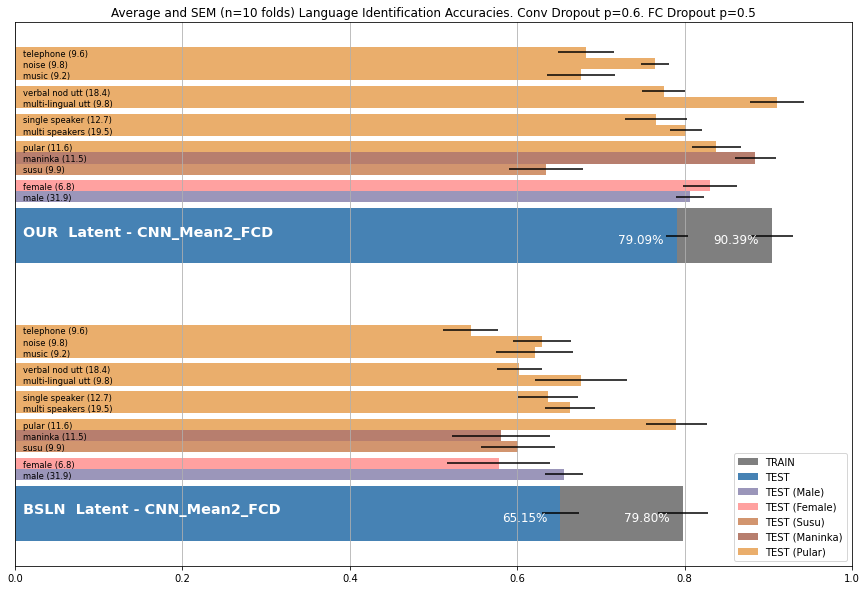

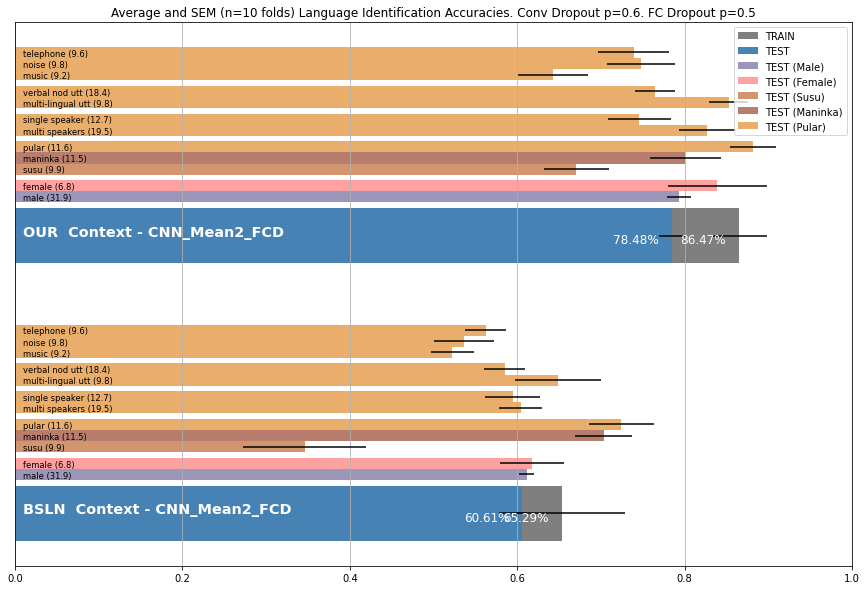

In [13]:
compared_features_latent = ['wav2vec_features-z', 'retrained-wav2vec_features-z']
compared_features_ctx = ['wav2vec_features-c', 'retrained-wav2vec_features-c']

for model_name in model_names:
    plot_summary_results([model_name], variables_and_sample_sizes, compared_features_latent)
    plot_summary_results([model_name], variables_and_sample_sizes, compared_features_ctx)


# Part 2 Model Attention Analysis

## Utilities from Training notebook

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import csv
from pathlib import Path
import h5py
import numpy as np

In [15]:
annotation_specification = {
    0: {
        'id': 0,
        'label': "maninka",
        'required_tags': set(['ct-speech', 'lng-maninka']),
        'forbidden_tags':  set(['lng-susu', 'lng-pular'])
    },
    1: {
        'id': 1,
        'label': "susu",
        'required_tags': set(['ct-speech', 'lng-susu']),
        'forbidden_tags':  set(['lng-maninka', 'lng-pular'])
    },
    2: {
        'id': 2,
        'label': "pular",
        'required_tags': set(['ct-speech', 'lng-pular']),
        'forbidden_tags':  set(['lng-susu', 'lng-maninka'])
    }
}

BASE_PATH = Path('/media/xtrem/data/experiments/nicolingua-0003-wa-wav2vec/test')
ANNOTATIONS_PATH = BASE_PATH / "metadata.csv"
FEATURE_DIRS = [
    BASE_PATH / 'wav2vec_features-c',
    BASE_PATH / 'wav2vec_features-z',
    BASE_PATH / 'retrained-wav2vec_features-c',
    BASE_PATH / 'retrained-wav2vec_features-z'
]

AUDIO_SAMPLES_PATH = BASE_PATH / "audio_samples"

FEATURE_NAMES = ['wav2vec_features-z', 'retrained-wav2vec_features-z']

#GPU_ID = 1
#device = torch.device(f"cuda:{GPU_ID}")
device = torch.device(f"cpu")

COLORS = ["#7f7f7f", "#1f77b4"]

In [16]:
def to_user_friendly_feature_name(fv_name):
    name = fv_name \
        .replace("features-", "") \
        .replace("wav2vec_", "") \
        .replace("average", "avg") \
        .replace("timestep", "T") \
        .replace("c.", "Context") \
        .replace("z.", "Latent")
    return name

In [17]:
def load_annotations(a_file_path, a_specification):
    with open(ANNOTATIONS_PATH) as f:
        reader = csv.DictReader(f)
        for row in reader:
            tag_set = set([t.strip() for t in row['tags'].split(";")])
            for label in annotation_specification.keys():
                spec = annotation_specification[label]
                if spec['required_tags'].issubset(tag_set):
                    if spec['forbidden_tags'].isdisjoint(tag_set):
                        yield row['file'], label, tag_set
                        break

data = list(load_annotations(ANNOTATIONS_PATH, annotation_specification))
audio_files, audio_labels, audio_tags = zip(*data)

In [18]:
def inspect_label_counts():
    for label in annotation_specification:
        count = len([l for l in audio_labels if l == label])
        print("{:10} ({}): {}".format(
            annotation_specification[label]['label'],
            label, 
            count
        ))
inspect_label_counts()

maninka    (0): 114
susu       (1): 32
pular      (2): 28


In [19]:
count_per_class = 28
data = list(load_annotations(ANNOTATIONS_PATH, annotation_specification))
balanced_data = []
for label in annotation_specification:
    balanced_data.extend([d for d in data if d[1] == label][:count_per_class])
audio_files, audio_labels, audio_tags = zip(*balanced_data)

In [20]:
inspect_label_counts()

maninka    (0): 28
susu       (1): 28
pular      (2): 28


In [21]:
def load_features(audio_files, features_input_dir):
    id_list = []
    features_list = []

    for audio_file_name in audio_files:
        feature_file_name = audio_file_name.replace(".wav", ".h5context")
        feature_path = Path(features_input_dir) / feature_file_name
        with h5py.File(feature_path, 'r') as f:
            features_shape = f['info'][1:].astype(int)
            features = np.array(f['features'][:]).reshape(features_shape)
            # features = pool_feature_last_seq(features)
            features_list.append(features)
    return features_list

In [22]:
raw_features = {}
for feature_dir in FEATURE_DIRS:
    feature_name = Path(feature_dir).stem
    raw_features[feature_name] = load_features(audio_files, feature_dir)

In [23]:
for feature_name in raw_features.keys():
    print("feature_name: {}. feature shape: {}".format(
        to_user_friendly_feature_name(feature_name),
        raw_features[feature_name][0].shape
    ))

feature_name: c. feature shape: (2998, 512)
feature_name: z. feature shape: (2998, 512)
feature_name: retrained-c. feature shape: (2998, 512)
feature_name: retrained-z. feature shape: (2998, 512)


In [24]:
class LangIdCNN_Mean2_FCD(nn.Module):
    def __init__(self, dropout_p, fc_dropout_p):
        super(LangIdCNN_Mean2_FCD, self).__init__()
        
        self.conv0 = nn.Conv1d(in_channels=512, out_channels=3, kernel_size=1)
        
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3)
        self.drop1 = nn.Dropout(p=dropout_p)
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3)
        self.drop2 = nn.Dropout(p=dropout_p)
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv1d(in_channels=3, out_channels=3, kernel_size=3)
        self.drop3 = nn.Dropout(p=dropout_p)
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv1d(in_channels=3, out_channels=3, kernel_size=3)
        self.drop4 = nn.Dropout(p=dropout_p)
        self.pool4 = nn.AvgPool1d(kernel_size=2, stride=2)
        
        self.drop5 = nn.Dropout(p=fc_dropout_p)

        self.lin6 = nn.Linear(in_features=9, out_features=3)
        
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        
        x = self.conv0(x)
        
        x = self.conv1(x)
        x = F.elu(x)
        x = self.drop1(x)
        x = self.pool1(x)
        
        
        x = self.conv2(x)
        x = F.elu(x)
        x = self.drop2(x)
        x = self.pool2(x)
        
        v1 = torch.mean(x, dim=2)
        
        x = self.conv3(x)
        x = F.elu(x)
        x = self.drop3(x)
        x = self.pool3(x)
        
        v2 = torch.mean(x, dim=2)
        
        x = self.conv4(x)
        x = F.elu(x)
        x = self.drop4(x)
        x = self.pool4(x)
        
        v3 = torch.mean(x, dim=2)
        
        v = torch.cat((v1, v2, v3), axis=1)
        v = self.drop5(v)
        
        x = self.lin6(v)
        
        return v, x

## Load best model checkpoints

In [25]:
def load_best_checkpoints(feature_names):
    best_checkpoints = []

    for model_name in model_names:
        for feature_name in feature_names:
            best_epochs = get_best_epochs_per_fold(model_name, feature_name, best_epoch_selection_variable='test_acc')
            #print(f'{model_name} {feature_name} {best_epochs}')
            for fold_id, epoch in enumerate(best_epochs):
                checkpoint_path = f'{DATA_DIR}/{model_name}/{feature_name}_{fold_id}_checkpoints/{epoch:04}.pt'
                checkpoint_data = torch.load(checkpoint_path)
                # print(f'Loaded {checkpoint_path}')

                assert(epoch == checkpoint_data['epoch'])
                assert(fold_id == checkpoint_data['fold_id'])
                assert(feature_name == checkpoint_data['feature_name'])
                assert(model_name == checkpoint_data['model_name'])

                dropout_p = checkpoint_data['dropout_p']
                fc_dropout_p = checkpoint_data['fc_dropout_p']

                model_state_dict = checkpoint_data['model_state_dict']
                # optimizer_state_dict = checkpoint_data['optimizer_state_dict']

                model = LangIdCNN_Mean2_FCD(dropout_p, fc_dropout_p)
                model.load_state_dict(model_state_dict)
                model.eval()

                best_checkpoints.append({
                    "feature_name": feature_name,
                    "fold_id": fold_id,
                    "model": model
                })
    return best_checkpoints
                

best_checkpoints = load_best_checkpoints(FEATURE_NAMES)
            
print(best_checkpoints)

[{'feature_name': 'wav2vec_features-z', 'fold_id': 0, 'model': LangIdCNN_Mean2_FCD(
  (conv0): Conv1d(512, 3, kernel_size=(1,), stride=(1,))
  (conv1): Conv1d(3, 1, kernel_size=(3,), stride=(1,))
  (drop1): Dropout(p=0.6, inplace=False)
  (pool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv2): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
  (drop2): Dropout(p=0.6, inplace=False)
  (pool2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv3): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (drop3): Dropout(p=0.6, inplace=False)
  (pool3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv4): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (drop4): Dropout(p=0.6, inplace=False)
  (pool4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (drop5): Dropout(p=0.5, inplace=False)
  (lin6): Linear(in_features=9, out_features=3, bias=True)
)}, {'feature_name': 'wav2vec_features-z', 'fold_id': 1, 'model': LangIdCNN_Mean2_FCD(
  (conv0): Conv1d(512, 3

# Compute data for attention visualization
- For each checkpoint:
    - representations
    - logits
    - class probabilities
    - KL divergences between predicted probabilities and one-hot ground truth probabilities
    - input graditents w.r.t. each predicted class logit

### One-hot audio labels

In [26]:
audio_labels_one_hot = np.zeros((len(audio_labels), 3))
for i in range(len(audio_labels)):
    audio_labels_one_hot[i, audio_labels[i]] = 1

### representations, logits, class probs, kl divs, gradients

In [27]:
for checkpoint in best_checkpoints:
    features = np.array(raw_features[checkpoint['feature_name']])
    x = torch.tensor(features, requires_grad=True).to(device)
    
    model = checkpoint['model'].to(device)
    representations, logits = model(x)
    class_probs = F.softmax(logits, dim=1)
    class_log_softmax = torch.log(class_probs)
    class_kl_divs = F.kl_div(class_log_softmax, torch.tensor(audio_labels_one_hot).to(device), reduction="none").sum(dim=1)
    
    
    checkpoint["representations"] = representations.detach().cpu().numpy()
    checkpoint["class_logits"] = logits.detach().cpu().numpy()
    checkpoint["class_probs"] = class_probs.detach().cpu().numpy()
    checkpoint["kl_divs"] = class_kl_divs.detach().cpu().numpy()
    
    checkpoint["input_gradients_by_class_index"] = {}
    
    for class_index in range(logits.shape[1]):
        class_input_gradients = torch.autograd.grad(logits[:, class_index].sum(), x, retain_graph=True)[0]
        checkpoint["input_gradients_by_class_index"][class_index] = class_input_gradients.detach().cpu().numpy()
        
    input_gradients = torch.autograd.grad(logits[:, :].sum(), x, retain_graph=True)[0]
    checkpoint["input_gradients"] = input_gradients.detach().cpu().numpy()
        
        
        

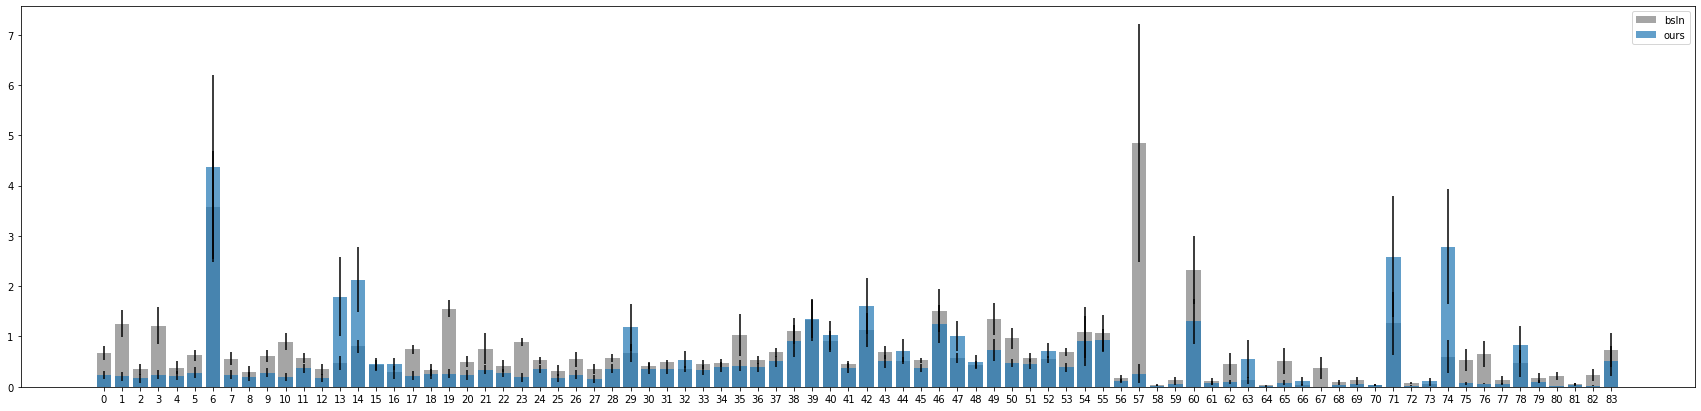

In [28]:
def get_kl_div_by_feature(best_checkpoints, feature_name):
    feature_best_checkpoints = [c for c in best_checkpoints if c['feature_name'] == feature_name]
    all_kl_divs = np.array([checkpoint['kl_divs'] for checkpoint in feature_best_checkpoints])
    mean_kl_divs = np.mean(all_kl_divs, axis=0)
    n_folds = all_kl_divs.shape[0]
    sem_kl_divs = np.std(all_kl_divs, axis=0) / np.sqrt(n_folds)
    
    return mean_kl_divs, sem_kl_divs

def get_datum_attention(best_checkpoints, feature_name, example_index):
    feature_best_checkpoints = [c for c in best_checkpoints if c['feature_name'] == feature_name]
    gradients = np.array([checkpoint['input_gradients'][example_index] for checkpoint in feature_best_checkpoints])
    # np.mean(gradients, axis=0)
    # print(gradients.shape)
    
    return gradients
    


mean_kl_divs_bsln, sem_kl_divs_bsln = get_kl_div_by_feature(best_checkpoints, "wav2vec_features-z")
mean_kl_divs_ours, sem_kl_divs_ours = get_kl_div_by_feature(best_checkpoints, "retrained-wav2vec_features-z")
    
plt.figure(figsize=(30, 7))
bar_width = 1
bar_margin = 2

x_bsln = np.arange(mean_kl_divs_bsln.shape[0])# * (bar_width + bar_margin)
x_ours = np.arange(mean_kl_divs_ours.shape[0])# * (bar_width + bar_margin) + 5
plt.bar(x_bsln, mean_kl_divs_bsln, alpha=0.7, color=BSLN_COLOR, yerr=sem_kl_divs_bsln)
plt.bar(x_ours, mean_kl_divs_ours, alpha=0.7, color=OUR_COLOR, yerr=sem_kl_divs_ours)
plt.xticks(x_bsln)

plt.legend(['bsln', 'ours'])

In [29]:
bsln_difficult_example_indices = np.argsort((mean_kl_divs_bsln - mean_kl_divs_ours) / mean_kl_divs_ours)[::-1]
print(bsln_difficult_example_indices)

[67 57 80 82 76 75 65  1 19  3 23 62 10 64 17 72  0 35 69  7 77 26 27  5
 21  9 59 20 68  2 50 12 49 25 53 58 60  4 79 28 11 22 24  8 83 61 31 45
 56 36 43 33 37 18 81 51 38 46 41 34 54 30 55 39 15 40 48 70  6 52 44 42
 32 16 29 47 78 71 73 66 14 13 63 74]


In [30]:
import IPython.display as ipd
import librosa
import librosa.display
import scipy

def resample_attention(al, temporal_bins):
    buckets = np.array_split(al, temporal_bins)
    resampled = np.array([np.mean(b) for b in buckets])
    return resampled
    
def display_datum(
    datum_index,
    datum_name, 
    bsln_mean_kld, our_mean_kld, 
    bsln_attention_line, bsln_attention_line_sem, bsln_special_attention,
    our_attention_line, our_attention_line_sem, our_special_attention):
    
    display(HTML(f"<h3>{datum_name} (index: {datum_index})</h3>"))
    display(HTML(f"<h4>Baseline KL-Divergence: {bsln_mean_kld:.03}</h4>"))
    display(HTML(f"<h4>Our KL-Divergence: {our_mean_kld:.03}</h4>"))
    display(HTML(f"<h4>Relative BSLN KL-Divergence of baseline w.r.t OURS: {(bsln_mean_kld - our_mean_kld) / our_mean_kld:.03%}</h4>"))
    
    
    
    audio_path = Path(AUDIO_SAMPLES_PATH) / datum_name
    display(ipd.Audio(audio_path))
    
    
    plt.figure(figsize=(30, 5))
    #fig, ax = plt.subplots(2, 1, sharex=True)

    x, sr = librosa.load(audio_path)
    
    
    ax1 = plt.subplot(411)
    display(librosa.display.waveplot(x, sr=sr))
    
    plt.subplot(412, sharex=ax1)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    display(librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz'))
    
    plt.subplot(413, sharex=ax1)
    
    # Note from wav2vec
    # The output of the encoder is a low frequency
    # feature representation zi ∈ Z which encodes about 30 ms of 16 kHz of audio and the striding results
    # in representations zi every 10ms. (10/1000 seconds)
    t_e = np.arange(bsln_attention_line.shape[0]) * (10/1000)
    t_e_ticks = np.arange(30000, step=500) / 1000
    ax1.set_xticks(t_e_ticks)
    ax1.set_xticklabels(t_e_ticks)
        
    plt.plot(t_e, bsln_attention_line, color=BSLN_COLOR)
    plt.fill_between(
        t_e, 
        bsln_attention_line - bsln_attention_line_sem,
        bsln_attention_line + bsln_attention_line_sem,
        alpha=0.3,
        color=BSLN_COLOR
    )
    
    
    plt.plot(t_e, our_attention_line, color=OUR_COLOR)
    plt.fill_between(
        t_e,
        our_attention_line - our_attention_line_sem,
        our_attention_line + our_attention_line_sem,
        alpha=0.3,
        color=OUR_COLOR
    )
    
    plt.legend(['bsln', 'our'])
    
    
    plt.subplot(414, sharex=ax1)
    plt.fill_between(t_e, 0, bsln_special_attention, color=BSLN_COLOR, alpha=0.5)
    plt.fill_between(t_e, 0, our_special_attention, color=OUR_COLOR, alpha=0.5)
    
    
    
        
    plt.show()
    

In [31]:
def generate_special_attention_segments(special_attention_series):
    current_state = special_attention_series[0]
    marker_begin_index = 0
    for index, spa in enumerate(special_attention_series):
        if spa != current_state:
            if spa:
                marker_begin_index = index
            else:
                marker_end_index = index
                
                yield marker_begin_index, marker_end_index
                
            current_state = spa
    
def generate_audacity_markers(fname, special_attention_series, marker_prefix):
    print(fname)
    marker_count = 0
    
    for marker_begin_index, marker_end_index in generate_special_attention_segments(special_attention_series):
        marker_count += 1
        
        marker_begin_time = marker_begin_index*(10/1000)
        marker_end_time = marker_end_index*(10/1000)
        marker_name = f'{marker_prefix}_{marker_count}'

        print(f"{marker_begin_time}\t{marker_end_time}\t{marker_name}")


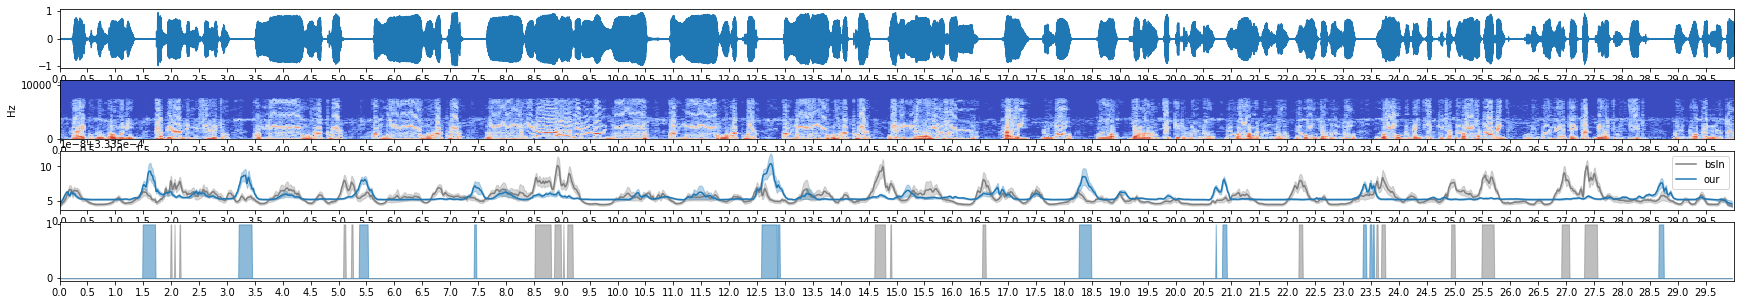

0f4c3c2e-5e44-4c7a-a2b7-95799919ee07.wav_bsln_attention.txt
1.99	2.0100000000000002	bsln_special_1
2.06	2.07	bsln_special_2
2.15	2.17	bsln_special_3
5.09	5.13	bsln_special_4
5.23	5.26	bsln_special_5
8.52	8.81	bsln_special_6
8.870000000000001	8.99	bsln_special_7
9.03	9.040000000000001	bsln_special_8
9.1	9.200000000000001	bsln_special_9
14.61	14.8	bsln_special_10
14.89	14.91	bsln_special_11
16.54	16.6	bsln_special_12
22.21	22.28	bsln_special_13
23.6	23.63	bsln_special_14
23.69	23.76	bsln_special_15
24.94	25.01	bsln_special_16
25.490000000000002	25.71	bsln_special_17
26.92	27.060000000000002	bsln_special_18
27.330000000000002	27.560000000000002	bsln_special_19
0f4c3c2e-5e44-4c7a-a2b7-95799919ee07.wav_out_attention.txt
1.49	1.72	our_special_1
3.21	3.45	our_special_2
5.37	5.53	our_special_3
7.43	7.47	our_special_4
12.58	12.86	our_special_5
12.870000000000001	12.91	our_special_6
18.27	18.490000000000002	our_special_7
20.72	20.73	our_special_8
20.84	20.92	our_special_9
23.36	23.42	our_special

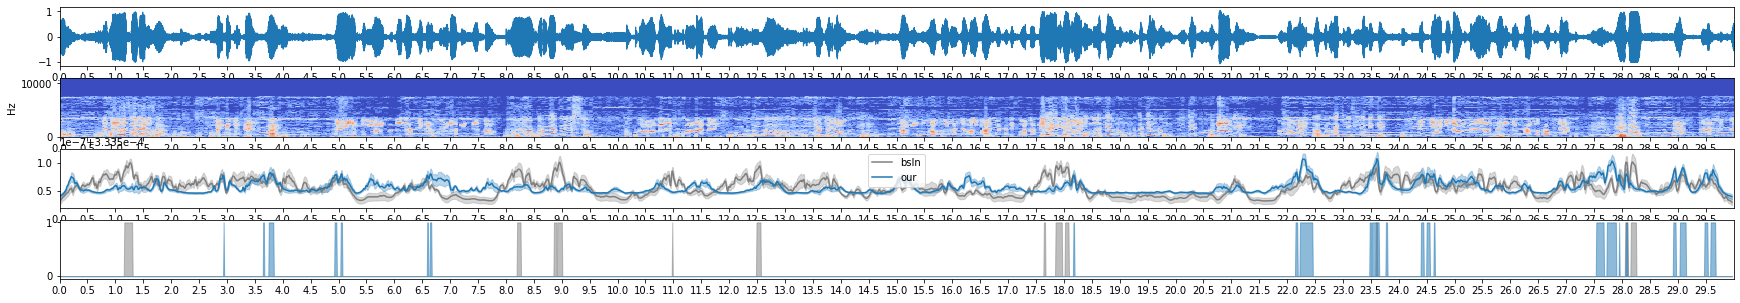

0c73a83d-c0fc-4ac4-994c-a2b14ede31cb.wav_bsln_attention.txt
1.16	1.31	bsln_special_1
8.2	8.27	bsln_special_2
8.86	8.91	bsln_special_3
8.92	9.01	bsln_special_4
10.98	10.99	bsln_special_5
12.49	12.57	bsln_special_6
17.64	17.67	bsln_special_7
17.85	17.97	bsln_special_8
18.02	18.09	bsln_special_9
23.59	23.62	bsln_special_10
28.060000000000002	28.11	bsln_special_11
28.16	28.26	bsln_special_12
0c73a83d-c0fc-4ac4-994c-a2b14ede31cb.wav_out_attention.txt
2.94	2.95	our_special_1
3.65	3.67	our_special_2
3.75	3.84	our_special_3
4.93	4.97	our_special_4
5.04	5.07	our_special_5
6.59	6.61	our_special_6
6.640000000000001	6.67	our_special_7
18.17	18.19	our_special_8
22.150000000000002	22.19	our_special_9
22.23	22.46	our_special_10
23.48	23.51	our_special_11
23.52	23.650000000000002	our_special_12
23.77	23.8	our_special_13
24.400000000000002	24.45	our_special_14
24.5	24.560000000000002	our_special_15
24.63	24.650000000000002	our_special_16
27.54	27.68	our_special_17
27.73	27.900000000000002	our_special_1

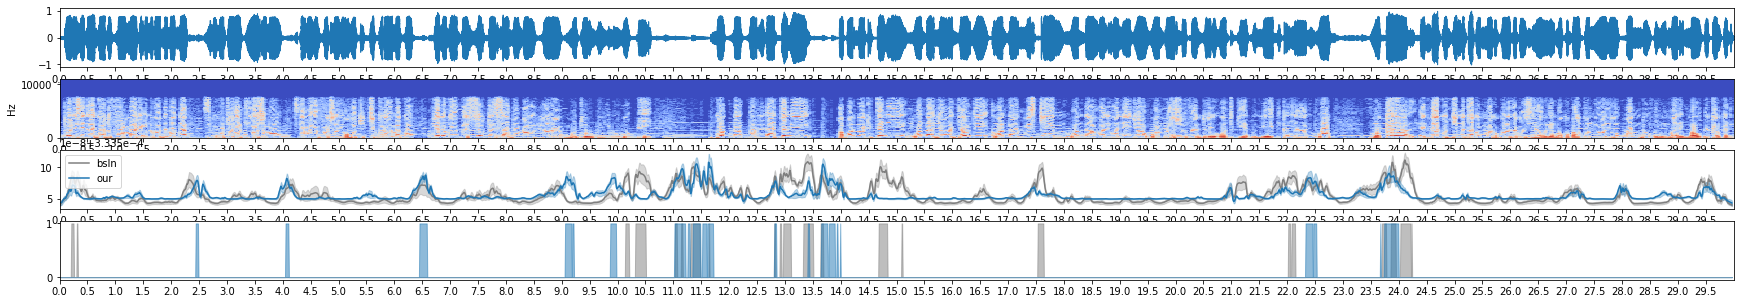

0c424e24-ac12-45d6-a830-4c828b0db2ec.wav_bsln_attention.txt
0.21	0.26	bsln_special_1
0.31	0.33	bsln_special_2
10.14	10.21	bsln_special_3
10.32	10.51	bsln_special_4
11.03	11.07	bsln_special_5
11.14	11.17	bsln_special_6
11.31	11.48	bsln_special_7
11.64	11.65	bsln_special_8
12.81	12.83	bsln_special_9
12.91	12.94	bsln_special_10
12.97	13.11	bsln_special_11
13.33	13.51	bsln_special_12
13.64	13.69	bsln_special_13
14.68	14.84	bsln_special_14
15.09	15.11	bsln_special_15
17.53	17.64	bsln_special_16
22.02	22.06	bsln_special_17
22.080000000000002	22.150000000000002	bsln_special_18
23.7	23.78	bsln_special_19
23.86	23.95	bsln_special_20
24.03	24.22	bsln_special_21
24.23	24.240000000000002	bsln_special_22
0c424e24-ac12-45d6-a830-4c828b0db2ec.wav_out_attention.txt
2.44	2.49	our_special_1
4.05	4.11	our_special_2
6.45	6.59	our_special_3
9.06	9.18	our_special_4
9.19	9.22	our_special_5
9.870000000000001	9.98	our_special_6
11.02	11.22	our_special_7
11.26	11.3	our_special_8
11.35	11.49	our_special_9
11.52	

In [32]:
def compute_attention_line(gradients, special_std_factor_threshold=2):
    return compute_attention_line_v2(gradients, special_std_factor_threshold=2)

def compute_attention_line_v1(gradients, special_std_factor_threshold=2):
    ## Compute the magnitude of the gradients
    gradient_magnitudes = np.abs(gradients)
    # print(f"gradient_magnitudes.shape: {gradient_magnitudes.shape}") # (10, 2998, 512)
    
    ## Sum the magnitudes across the 512 neurons
    gradient_sums_accross_neurons = np.sum(gradient_magnitudes, axis=2)
    # print(f"gradient_sums_accross_neurons.shape: {gradient_sums_accross_neurons.shape}")# (10, 2998)
    
    ## Softmax the summed magnitudes over the temporal dimension
    normalized_attention_lines = scipy.special.softmax(gradient_sums_accross_neurons, axis=1)
    
    # print(f"normalized_attention_lines.shape: {normalized_attention_lines.shape}") # (10, 2998)
    
    ## Compute the mean and STEM attentions across folds
    fold_count = normalized_attention_lines.shape[0]
    mean_attention_line = np.mean(normalized_attention_lines, axis=0)
    sem_attention_lines = np.std(normalized_attention_lines, axis=0) / np.sqrt(fold_count)
    # print(f"mean_attention_line.shape: {mean_attention_line.shape}") # (2998,)
    
    ## Identify special attention temporal regions as regions that receive attention 2 STD above the mean
    mean_ponctual_attention = np.mean(mean_attention_line)
    std_ponctual_attention = np.std(mean_attention_line)
    
    special_attention = mean_attention_line > (mean_ponctual_attention + special_std_factor_threshold*std_ponctual_attention)
    #print(f"special_attention.shape: {special_attention.shape}") # (2998,)
    
    return mean_attention_line, sem_attention_lines, special_attention
    
    
def compute_attention_line_v2(gradients, special_std_factor_threshold=2):
    ## Compute the magnitude of the gradients
    gradient_magnitudes = np.abs(gradients)
    # print(f"gradient_magnitudes.shape: {gradient_magnitudes.shape}") # (10, 2998, 512)
    
    ## Sum the magnitudes across the 512 neurons
    normalized_neuron_contributions = scipy.special.softmax(gradient_magnitudes, axis=1)
    gradient_sums_accross_neurons = np.sum(normalized_neuron_contributions, axis=2)
    # print(f"gradient_sums_accross_neurons.shape: {gradient_sums_accross_neurons.shape}")# (10, 2998)
    
    ## Softmax the summed magnitudes over the temporal dimension
    normalized_attention_lines = scipy.special.softmax(gradient_sums_accross_neurons, axis=1)
    
    # print(f"normalized_attention_lines.shape: {normalized_attention_lines.shape}") # (10, 2998)
    
    ## Compute the mean and STEM attentions across folds
    fold_count = normalized_attention_lines.shape[0]
    mean_attention_line = np.mean(normalized_attention_lines, axis=0)
    sem_attention_lines = np.std(normalized_attention_lines, axis=0) / np.sqrt(fold_count)
    # print(f"mean_attention_line.shape: {mean_attention_line.shape}") # (2998,)
    
    ## Identify special attention temporal regions as regions that receive attention 2 STD above the mean
    mean_ponctual_attention = np.mean(mean_attention_line)
    std_ponctual_attention = np.std(mean_attention_line)
    
    special_attention = mean_attention_line > (mean_ponctual_attention + special_std_factor_threshold*std_ponctual_attention)
    #print(f"special_attention.shape: {special_attention.shape}") # (2998,)
    
    return mean_attention_line, sem_attention_lines, special_attention
    
for example_index in bsln_difficult_example_indices[:3]:
    bsln_gradients = get_datum_attention(best_checkpoints, 'wav2vec_features-z', example_index)
    our_gradients = get_datum_attention(best_checkpoints, 'retrained-wav2vec_features-z', example_index)
    
    bsln_attention_line, bsln_attention_sem_line, bsln_special_attention = compute_attention_line(bsln_gradients, special_std_factor_threshold=2)
    
    # print(our_gradients.shape[0] * )
    our_attention_line, our_attention_sem_line, our_special_attention = compute_attention_line(our_gradients, special_std_factor_threshold=2)
    
    
    
    display_datum(
        datum_index = example_index,
        datum_name = audio_files[example_index], 
        bsln_mean_kld = mean_kl_divs_bsln[example_index], 
        our_mean_kld = mean_kl_divs_ours[example_index], 
        bsln_attention_line = bsln_attention_line, 
        bsln_attention_line_sem = bsln_attention_sem_line, 
        bsln_special_attention = bsln_special_attention,
        our_attention_line = our_attention_line, 
        our_attention_line_sem = our_attention_sem_line,
        our_special_attention = our_special_attention
    )
    
    generate_audacity_markers(
        f"{audio_files[example_index]}_bsln_attention.txt",
        bsln_special_attention,
        'bsln_special'
    )
    
    generate_audacity_markers(
        f"{audio_files[example_index]}_out_attention.txt",
        our_special_attention,
        'our_special'
    )
        

In [33]:
x = np.random.randn(10, 2998, 512)
s = scipy.special.softmax(x, axis=(1))
print(s.shape)

(10, 2998, 512)


In [34]:
print(s[0].shape)
np.sum(s[0], axis=0)

(2998, 512)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

# Part 3 Clustering special attention segments

In [83]:
def get_special_attention_segment_features(example_index, feature_name):
    gradients = get_datum_attention(best_checkpoints, feature_name, example_index)

    attention_line, attention_sem_line, special_attention = compute_attention_line(gradients, special_std_factor_threshold=2)
    example_feature = raw_features[feature_name][example_index]
    
    for start_index, end_index in generate_special_attention_segments(special_attention):
        #segment_feature = np.mean(example_feature[start_index:end_index+1], axis=0)
        segment_feature = np.mean(example_feature[start_index:end_index+1], axis=0)
        yield segment_feature
    
    #for i, special in enumerate(special_attention):
    #    if special:
            # yield np.mean(example_feature[i-2: i+3], axis=0)
            # yield np.mean(example_feature[i-5: i+6], axis=0)
    #        yield np.mean(example_feature[i-3:i+4], axis=0)
        

feature_names = ['wav2vec_features-z', 'retrained-wav2vec_features-z']
special_att_seg_features = {f:[] for f in feature_names}
special_att_seg_classes = {f:[] for f in feature_names}
special_att_seg_clips = {f:[] for f in feature_names}


for example_index in bsln_difficult_example_indices[:20]:
    for feature_name in feature_names:
        for v in get_special_attention_segment_features(example_index, feature_name):
            special_att_seg_features[feature_name].append(v)
            special_att_seg_classes[feature_name].append(audio_labels[example_index])
            special_att_seg_clips[feature_name].append(example_index)
    
for feature_name in feature_names:
    special_att_seg_features[feature_name] = np.array(special_att_seg_features[feature_name])
    print(feature_name, special_att_seg_features[feature_name].shape)

wav2vec_features-z (365, 512)
retrained-wav2vec_features-z (406, 512)


In [84]:
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding, MDS

In [85]:
def plot_projection(vectors, classes, feature_name, perplexity=5, n_iter=5000, learning_rate=200, early_exaggeration=12, scale=100, alpha=1, title="projection", algo="tsne", by_audio_clip=False):
    if algo == 'spectral':
        vectors_2d = SpectralEmbedding(random_state=42).fit_transform(vectors)
    elif algo == 'mds':
        vectors_2d = MDS(random_state=42, metric=True).fit_transform(vectors)
    else:
        vectors_2d = TSNE(
            random_state=42, 
            perplexity=perplexity, 
            n_iter=n_iter,
            learning_rate=learning_rate,
            early_exaggeration=early_exaggeration
        ).fit_transform(vectors)
    
    print(vectors_2d.shape)
    
    
    lang_colors = ["#2ca02c", "#d62728", "#9467bd"]
    lang_counts = {}
    
    
    plt.figure(figsize=(10, 10))
    print(len(COLOR_PALETTE))
    if by_audio_clip:
        clip_indices = sorted(set(special_att_seg_clips[feature_name]))
        color_by_clip_index = {clip_ix:COLOR_PALETTE[pos] for pos, clip_ix in enumerate(clip_indices)}
        colors = [color_by_clip_index[clip_ix] for clip_ix in special_att_seg_clips[feature_name]]
                               
        
        
        plt.scatter(
            vectors_2d[:,0], 
            vectors_2d[:,1], 
            s=scale, 
            c=colors, #special_att_seg_clips[feature_name], 
            alpha=alpha
        )
        
        plt.title(title)
        plt.legend(special_att_seg_clips[feature_name])
    else:
        for class_id in annotation_specification.keys():
            label = annotation_specification[class_id]['label']
            x = [vectors_2d[i,0] for i in range(vectors_2d.shape[0]) if classes[i] == class_id]
            y = [vectors_2d[i,1] for i in range(vectors_2d.shape[0]) if classes[i] == class_id]
            count = len(x)
            plt.scatter(x, y, s=scale, c=lang_colors[class_id], label=f"{label} ({count})", alpha=alpha)


            plt.title(title)
            plt.legend()
    
    plt.show()

(365, 2)
21


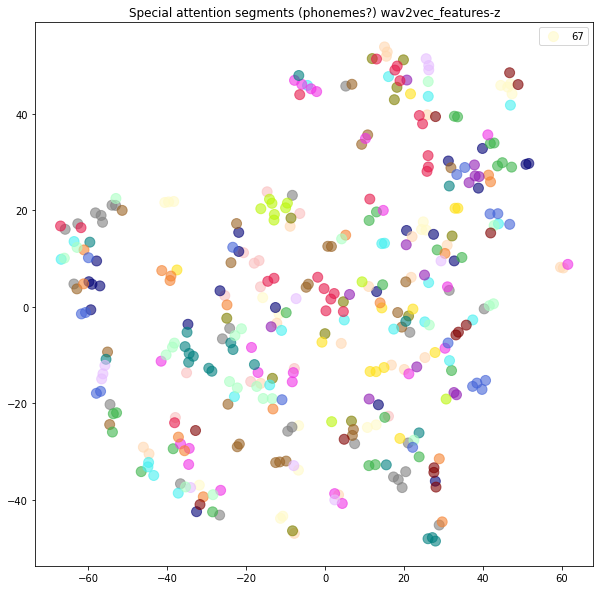

(365, 2)
21


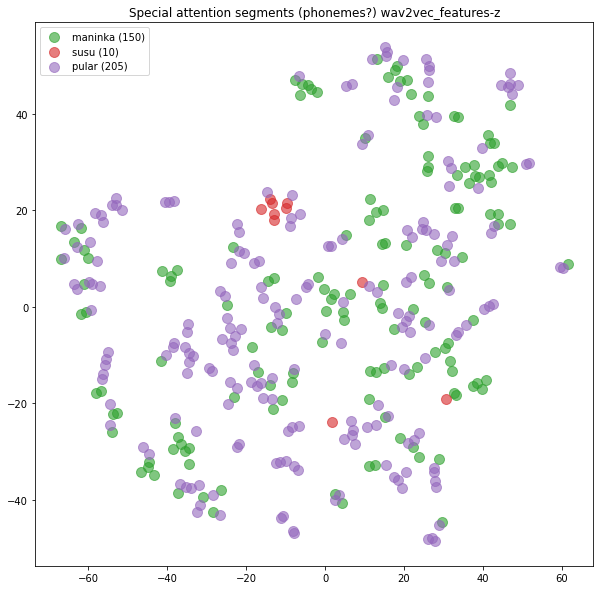

(406, 2)
21


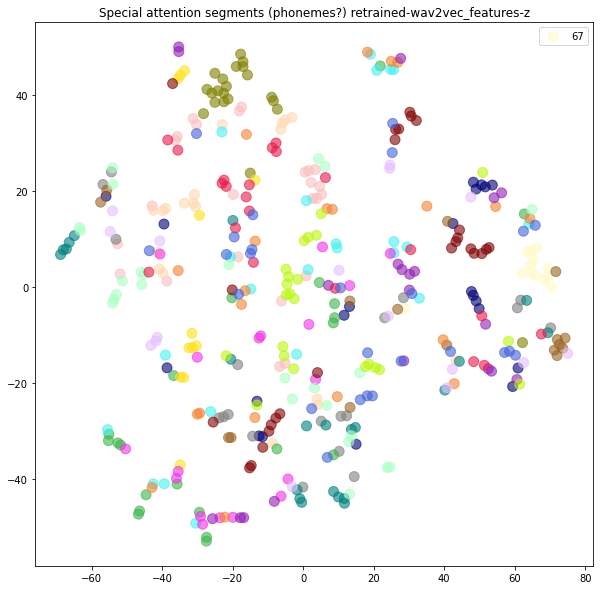

(406, 2)
21


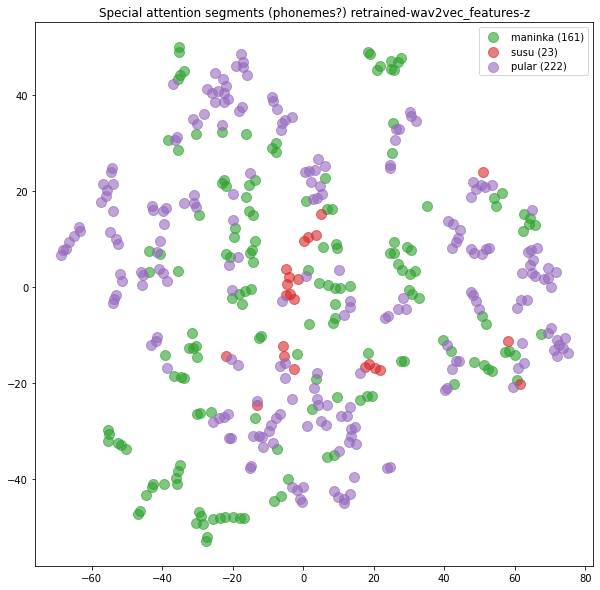

In [100]:
for feature_name in feature_names:
    #segments_per_class = 100
    
    #indices_by_class = {i:[] for i in range(3)}
    #for index, class_id in enumerate(special_att_seg_classes[feature_name]):
    #    indices_by_class[class_id].append(index)
    
    #selected_indices = []
    #for class_id in range(3):
    #    selected_indices.extend(
    #        np.random.choice(indices_by_class[class_id], size=segments_per_class, replace=False)
    #    )
    
    
    #plot_projection(
    #    np.take(special_att_seg_features[feature_name], selected_indices, axis=0),
    #    np.take(special_att_seg_classes[feature_name], selected_indices),
    #    feature_name,
    #    perplexity=20, 
    #    n_iter=1000, 
    #    scale=100, 
    #    alpha=0.8, 
    #    title=f"Special attention segments (phonemes?) {feature_name}",
    #)
    
    
    for by_audio_clip in [True, False]:
        plot_projection(
            special_att_seg_features[feature_name],
            special_att_seg_classes[feature_name],
            feature_name,
            perplexity=5,  #200, 
            n_iter=1000,
            learning_rate=200, 
            early_exaggeration=5, #5,
            scale=100, 
            alpha=0.6, 
            title=f"Special attention segments (phonemes?) {feature_name}",
            by_audio_clip=by_audio_clip
        )    

In [101]:
def get_representations(feature_name):
    return np.array([ckpt['representations'] for ckpt in best_checkpoints if ckpt['feature_name'] == feature_name])

(10, 84, 9)
(84, 90)
(84, 2)
21


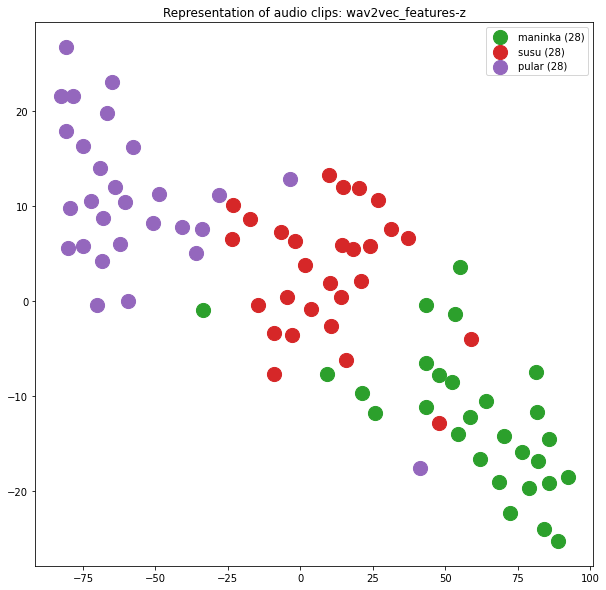

(10, 84, 9)
(84, 90)
(84, 2)
21


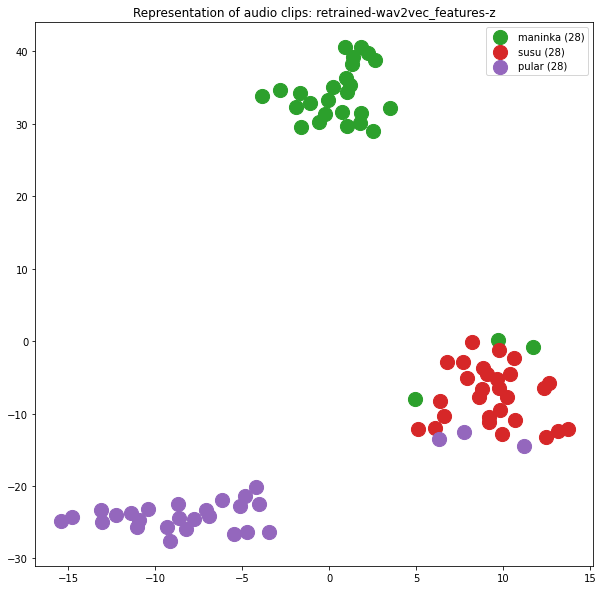

In [108]:
for feature_name in feature_names:
    representations = get_representations(feature_name)
    print(representations.shape)
    representations = np.concatenate(representations, axis=1)
    #representations = np.mean(representations, axis=0)
    
    print(representations.shape)
    
    plot_projection(
        representations, 
        audio_labels, 
        feature_name, 
        perplexity=10, 
        n_iter=5000,
        learning_rate=200, 
        early_exaggeration=5,
        scale=200, 
        alpha=1,
        title=f"Representation of audio clips: {feature_name}"
    )
